# Bitcoin Reinforcement Learning

## Assumptions
* Agent's actions are small enough that it will not affect the future price of bitcon. (If so, will reinforcement learning be affective?)
* Agent will make decisions and execute transactions in a fixed timestep.
* The price of latest transaction will be the price of bitcoin at that time.

In [1]:
from IPython.display import clear_output

In [2]:
from enum import Enum, unique
from collections import deque
import random

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


In [5]:
btc_csv = pd.read_csv("coinbaseUSD.csv", header = None, usecols = [0, 1], names = ["timestamp", "price"])

In [6]:
btc_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18192817 entries, 0 to 18192816
Data columns (total 2 columns):
timestamp    int64
price        float64
dtypes: float64(1), int64(1)
memory usage: 277.6 MB


In [7]:
btc_csv.head(5)

,timestamp,price
0,1417412036,300.0
1,1417412423,300.0
2,1417415048,370.0
3,1417416612,370.0
4,1417498166,377.0


In [8]:
btc_csv.describe()

,timestamp,price
count,1.819282e+07,1.819282e+07
mean,1.465828e+09,8.738391e+02
std,2.354160e+07,7.622207e+02
min,1.417412e+09,6.000000e-02
25%,1.446888e+09,3.479200e+02
50%,1.464890e+09,5.389900e+02
75%,1.489606e+09,1.142120e+03
max,1.500333e+09,2.999990e+03


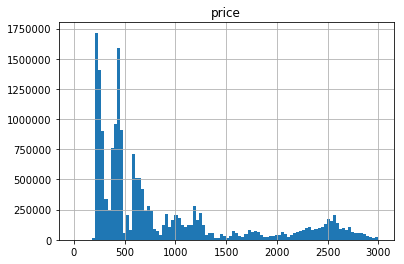

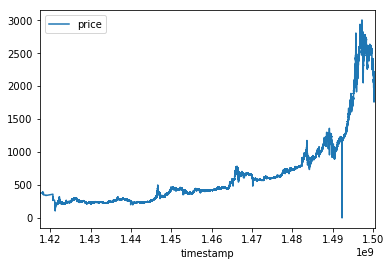

In [9]:
plt.clf()
btc_csv.hist(column = "price", bins=100)
btc_csv.plot(x = "timestamp", y = "price")
plt.show()

In [10]:
TIMESTEP = 1000

btc_np = btc_csv.values
current_timestamp = btc_np[0, 0]
current_price = btc_np[0, 1]
fixed_btc_data = np.empty((0, 2))

for x in btc_np[1:]:
    target_timestamp = x[0]
    
    while current_timestamp < target_timestamp:
        row = [[current_timestamp, current_price]]
        fixed_btc_data = np.append(fixed_btc_data, row, axis = 0)
        current_timestamp += TIMESTEP
    
    current_price = x[1]

In [11]:
fixed_btc_data_df = pd.DataFrame(data = fixed_btc_data, columns = ["timestamp", "price"])

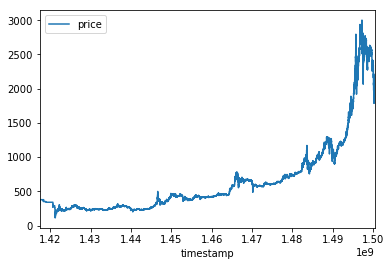

In [12]:
plt.clf()
fixed_btc_data_df.plot(x = "timestamp", y = "price")
plt.show()

In [13]:
class BTCAgent(object):
    """
    Will this make me rich?
    """
    
    @unique
    class Action(Enum):
        BUY_HALF = 0
        BUY_MAX = 1
        HOLD = 2
        SELL_HALF = 3
        SELL_MAX = 4
    
    def __init__(self, btc_data, replay_memory_size = 300000, context_size = 100, num_iterations = 1, batch_size = 32):
        self.btc_data = btc_data
        self.usd_amount = 200
        self.btc_amount = 0
        self.replay_memory = deque(maxlen=replay_memory_size)
        self.state = np.zeros((1, 3, 1, context_size))
        self.num_iterations = num_iterations
        self.batch_size = batch_size
        self.epsilon = 1.0
    
    def _calculate_total_asset(self, usd_amount, btc_amount, btc_price):
        return usd_amount + btc_amount * btc_price
    
    def _execute_order(self, action_index, usd_amount, btc_amount, btc_price, next_btc_price):
        action = self.Action(action_index)
        
        if action == self.Action.BUY_HALF: # BUY
            next_usd_amount = usd_amount / 2.0
            next_btc_amount = btc_amount + usd_amount / (2.0 * btc_price)
            
        if action == self.Action.BUY_MAX: # BUY
            next_usd_amount = 0.0
            next_btc_amount = btc_amount + usd_amount / btc_price

        if action == self.Action.HOLD: # HOLD
            next_usd_amount = usd_amount
            next_btc_amount = btc_amount

        if action == self.Action.SELL_HALF: # SELL
            next_usd_amount = usd_amount + (btc_amount / 2.0) * btc_price
            next_btc_amount = btc_amount / 2.0
            
        if action == self.Action.SELL_MAX: # SELL
            next_usd_amount = usd_amount + btc_amount * btc_price
            next_btc_amount = 0.0

        total_asset = self._calculate_total_asset(usd_amount, btc_amount, btc_price)
        next_total_asset = self._calculate_total_asset(next_usd_amount, next_btc_amount, next_btc_price)
        reward = next_total_asset - total_asset

        return next_usd_amount, next_btc_amount, reward
    
    def _initialize_q_function(self):
        model = Sequential()

        model.add(Convolution2D(filters=128, kernel_size=(2, 1), padding='valid', activation='relu', input_shape=(3, 1, self.state.shape[-1])))
        model.add(Dropout(0.05))

        model.add(Convolution2D(filters=256, kernel_size=(1, 1), padding='valid', activation='relu'))
        model.add(Dropout(0.10))

        model.add(Convolution2D(filters=512, kernel_size=(1, 1), padding='valid', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 1), padding='valid'))
        model.add(Dropout(0.05))
        
        model.add(Flatten())

        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(len(self.Action.__members__), activation='softmax'))
        
        model.compile(loss='mse', optimizer='adam')
        
        return model
    
    def _get_action(self):
        if random.random() < self.epsilon:
            return random.choice(range(len(self.Action.__members__)))
        else:
            action_values = self.model.predict(self.state)
            return np.argmax(action_values)
    
    def run(self):
        K.clear_session()
        self.model = self._initialize_q_function()
        
        self.epoches = []
        self.trade_returns = []
        self.static_returns = []

        start_btc_price = self.btc_data[0, 1]
        usd_wallet = self.usd_amount
        btc_wallet = self.btc_amount
        
        s_1 = np.zeros((3, 1))
        s_1[0, 0] = start_btc_price
        s_1[1, 0] = usd_wallet
        s_1[2, 0] = btc_wallet
        
        self.state = np.stack([s_1] * self.state.shape[-1], axis=2)
        self.state = self.state.reshape(1, self.state.shape[0], self.state.shape[1], self.state.shape[2])
        
        loss = float('Inf')
        store = [0] * len(self.Action.__members__)

        for index in range(1, self.btc_data.shape[0] - 1):
            self.epsilon = max(1 - (index / float(1000)), 0.1)
            
            btc_price = self.btc_data[index, 1]
            next_btc_price = self.btc_data[index+1, 1]
            
            if index % 100 == 0:
                clear_output()
                
                potential_asset = (self.usd_amount / start_btc_price + self.btc_amount) * btc_price
                begin_asset = self._calculate_total_asset(self.usd_amount, self.btc_amount, start_btc_price)
                total_asset = self._calculate_total_asset(usd_wallet, btc_wallet, btc_price)
                print("Index %d, epsilon %.02f" % (index, self.epsilon))
                
                for a_index, count in enumerate(store):
                    print("%s -- %d / 100" % (self.Action(a_index), count))
                
                print("Total asset: $%.02f USD ($%.02f USD, %0.2f BTC)" % (total_asset, usd_wallet, btc_wallet))
                print("Close BTC price: $%.02f USD / BTC" % (btc_price))
                print("Trade return: $%.02f USD" % (total_asset - begin_asset))
                print("Static return: $%.02f USD" % (potential_asset - begin_asset))
                print("Model loss: %.02f" % (loss))
                
                self.epoches.append(index)
                self.trade_returns.append(total_asset - begin_asset)
                self.static_returns.append(potential_asset - begin_asset)
                
                plt.clf()
                plt.plot(self.epoches, self.trade_returns, 'r', self.epoches, self.static_returns, 'b')
                plt.show()
                
                loss = 0
                store = [0] * len(self.Action.__members__)

            ### Run
            action = self._get_action()
            store[action] += 1
            next_usd_wallet, next_btc_wallet, reward = self._execute_order(action, usd_wallet, btc_wallet, btc_price, next_btc_price)

            s_n = np.zeros((3, 1))
            s_n[0, 0] = next_btc_price
            s_n[1, 0] = next_usd_wallet
            s_n[2, 0] = next_btc_wallet
            
            s_n = s_n.reshape(1, s_n.shape[0], s_n.shape[1], 1)
            next_state = np.append(s_n, self.state[:, :, :, :(self.state.shape[-1] - 1)], axis=3)

            self.replay_memory.append((self.state, action, reward, next_state))

            ### Training
            if len(self.replay_memory) > self.batch_size:
                minibatch = random.sample(self.replay_memory, self.batch_size)

                inputs = np.zeros((self.batch_size, self.state.shape[1], self.state.shape[2], self.state.shape[3]))
                targets = np.zeros((self.batch_size, len(self.Action.__members__)))

                for i in range(self.batch_size):
                    state_t, action_t, reward_t, next_state_t = minibatch[i]

                    inputs[i] = state_t
                    targets[i] = self.model.predict(state_t)
                    next_action_values = self.model.predict(next_state_t)

                    targets[i, action_t] = reward_t + 0.99 * np.max(next_action_values)

                loss += self.model.train_on_batch(inputs, targets)

            ### Update
            usd_wallet = next_usd_wallet
            btc_wallet = next_btc_wallet
            self.state = next_state

In [14]:
agent = BTCAgent(fixed_btc_data)

Index 82900, epsilon 0.10
Action.BUY_HALF -- 90 / 100
Action.BUY_MAX -- 3 / 100
Action.HOLD -- 1 / 100
Action.SELL_HALF -- 4 / 100
Action.SELL_MAX -- 2 / 100
Total asset: $1144.30 USD ($0.00 USD, 0.55 BTC)
Close BTC price: $2087.46 USD / BTC
Trade return: $944.30 USD
Static return: $1191.64 USD
Model loss: 96.26


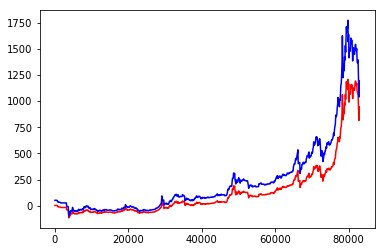

In [15]:
agent.run()

In [16]:
agent.model.save('trained_model.h5')